In [46]:
import sys
sys.path.append("..")# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# For data manipulation
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm

# Import adfuller
from statsmodels.tsa.stattools import adfuller# For statistical analysis

from statsmodels.tsa.arima.model import ARIMA#for price data
import yfinance as yf
import pandas_datareader.data as web

In [62]:
# Define the symbol, start, and end dates for the Nifty index

symbol = 'TSLA'
start = '2010-01-01'
end = '2023-12-31' # Download weekly closing price data for Nifty from Yahoo Finance

data = yf.download(symbol, start=start, end=end, interval='1d')[['Adj Close']] # Display the first few rows of the data
data.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000


In [63]:
import pandas as pd

def sanity_check(data): 
    """ Check for and handle data issues such as missing values and extreme outliers. 
    Parameters: - data (DataFrame): The DataFrame containing the 'Adj Close' prices of the Nifty index. 
    Returns: - DataFrame: The cleaned and potentially modified DataFrame. """ # Check for missing values
    if data.isnull().values.any(): 
        print("Missing values found.") # Filling missing values with the previous day's prices (forward fill) 
        data.fillna(method='ffill', inplace=True) 
        print("Missing values have been forward-filled.") 
    else: 
        print("No missing values in the data.") 
    return data
data = sanity_check(data)

No missing values in the data.


In [64]:
# Check for invalid/NaN 
print(data.isnull().sum())

Adj Close    0
dtype: int64


In [65]:
def check_stationarity(df): 
    adf_result = adfuller(df) 
    if(adf_result[1] < 0.05): 
        print('Data is stationary') 
    else: 
        print('Data is not stationary')

# Checking the Adj Close for stationarity
check_stationarity(data['Adj Close'])

Data is not stationary


In [66]:
# Check the differenced asset 1 for stationarity
check_stationarity(data['Adj Close'].diff().dropna())

Data is stationary


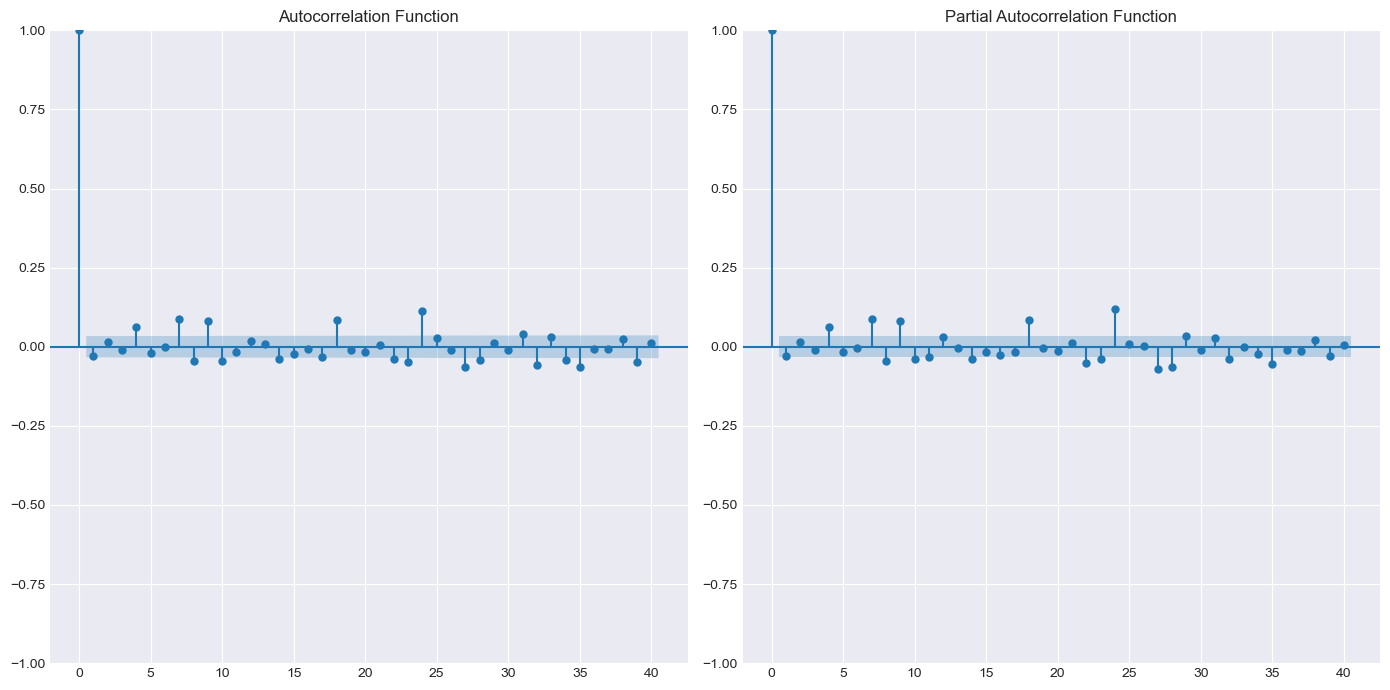

In [67]:
# Importing neccessary module 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # To accurately map the acf and pacf, we need a stationary series
diff_data = data['Adj Close'].diff().dropna() # Plotting ACF
plt.figure(figsize=(14, 7))
plt.subplot(121) # 1 row, 2 columns, 1st subplot
plot_acf(diff_data, ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function') # Plotting 
plt.subplot(122) # 1 row, 2 columns, 2nd subplot
plot_pacf(diff_data, ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

In [68]:
# Splitting the data into train and test that we can use the test data to evaluate our chosen model
split = int(len(data)*0.8)
data_train = data[:split]
data_test = data[split:]
print(data_train.shape[0], data_test.shape[0])

2720 680


In [69]:
import warnings
import pmdarima as pm

def find_best_arima_parameters(data_series, seasonal=False, m=1):
    model = pm.auto_arima(data_series, seasonal=seasonal, m=m, trace=True, error_action='ignore', suppress_warnings=True) # Extracting the best ARIMA order 
    best_order = model.order # This gives (p, d, q) # Optionally, print the summary of the best model 
    print(model.summary())
    return best_order

best_param = find_best_arima_parameters(data_train['Adj Close'])
print("Best ARIMA parameters (p, d, q):", best_param)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=14541.155, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=13680.305, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=14539.157, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=13181.609, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=12983.709, Time=0.25 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=12970.894, Time=0.35 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=12840.214, Time=0.43 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=12838.215, Time=0.33 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=12968.898, Time=0.33 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Ti

In [70]:
def get_predicted_prices(close_prices, best_param): # Defining the best model 
    best_model = ARIMA(close_prices.values, order=best_param) 
    best_model_fit = best_model.fit(method_kwargs={"warn_convergence": False}) # Making forecast 
    predictions = best_model_fit.forecast(steps=1)[0] 
    return predictions

predictions = []
for i in range(len(data_test['Adj Close'])): # Incrementally adding test data to simulate a rolling forecast 
    current_data = pd.concat([data_train['Adj Close'], data_test['Adj Close'].iloc[:i]]) 
    next_pred = get_predicted_prices(current_data, best_param) 
    predictions.append(next_pred) # Converting the predictions list to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['predicted_price'])
predictions_df.index = data_test.index
predictions_df


,predicted_price
Date,
2021-04-20,238.508135
2021-04-21,243.085239
2021-04-22,244.993402
2021-04-23,239.393458
2021-04-26,244.392990
...,...
2023-12-22,256.408141
2023-12-26,253.309601
2023-12-27,256.172791


In [71]:
data_test = pd.concat([data_test, predictions_df], axis=1)
data_test['predicted_returns'] = data_test['predicted_price'].pct_change()
data_test['actual_returns'] = data_test['Adj Close'].pct_change()
data_test.dropna(inplace=True)
#signal generation

data_test['signal'] = np.where(data_test['predicted_returns'] >=0, 1, -1)
#we may approach differently here and assume that we have learnt the predicted prices in advance and will be able to position ourselves
data_test['strategy_returns'] = data_test['signal'] * data_test['actual_returns']
data_test['cumulative_returns'] = np.cumprod(data_test['strategy_returns']+1)
data_test

,Adj Close,predicted_price,predicted_returns,actual_returns,signal,strategy_returns,cumulative_returns
Date,,,,,,,
2021-04-21,248.039993,243.085239,0.019191,0.034952,1,0.034952,1.034952
2021-04-22,239.896667,244.993402,0.007850,-0.032831,1,-0.032831,1.000974
2021-04-23,243.133331,239.393458,-0.022858,0.013492,-1,-0.013492,0.987469
2021-04-26,246.066666,244.392990,0.020884,0.012065,1,0.012065,0.999382
2021-04-27,234.913330,244.652021,0.001060,-0.045326,1,-0.045326,0.954084
...,...,...,...,...,...,...,...
2023-12-22,252.539993,256.408141,0.029428,-0.007701,1,-0.007701,1.193092
2023-12-26,256.609985,253.309601,-0.012084,0.016116,-1,-0.016116,1.173864
2023-12-27,261.440002,256.172791,0.011303,0.018822,1,0.018822,1.195958


In [72]:
#buy and hold returns
buy_and_hold_returns = (1+data_test['actual_returns']).cumprod()
buy_and_hold_returns

Date
2021-04-21    1.034952
2021-04-22    1.000974
2021-04-23    1.014479
2021-04-26    1.026718
2021-04-27    0.980181
                ...   
2023-12-22    1.053728
2023-12-26    1.070710
2023-12-27    1.090864
2023-12-28    1.056399
2023-12-29    1.036788
Name: actual_returns, Length: 679, dtype: float64

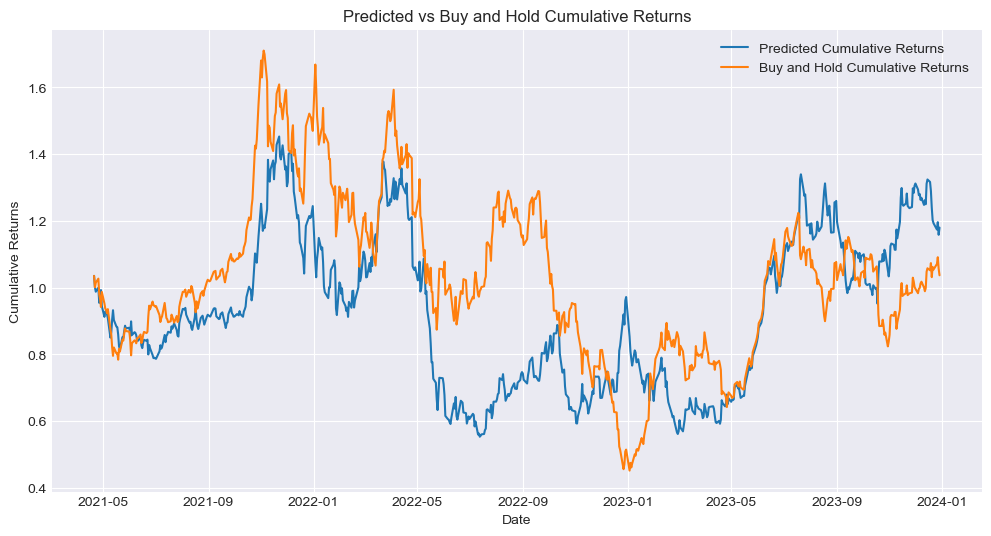

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(data_test['cumulative_returns'], label='Predicted Cumulative Returns')
plt.plot(buy_and_hold_returns, label='Buy and Hold Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Predicted vs Buy and Hold Cumulative Returns')
plt.legend()
plt.show()

The maximum drawdown of the strategy is -61.96


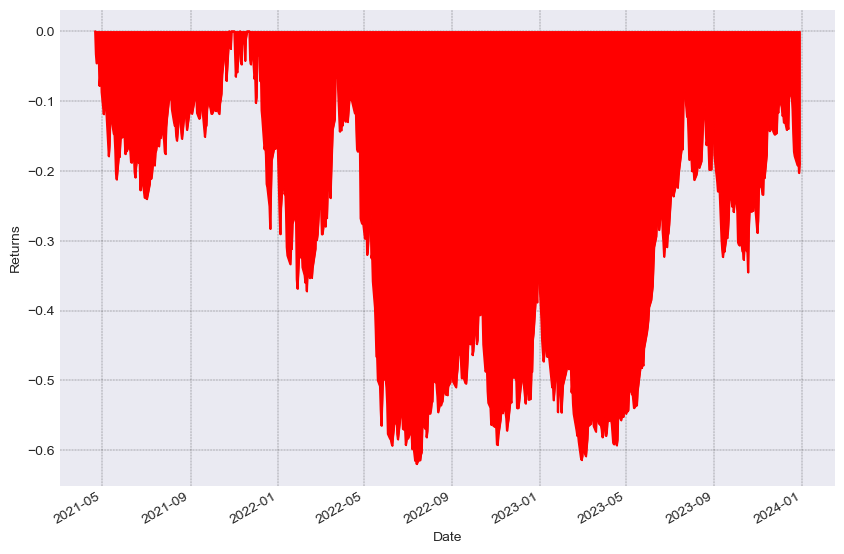

In [74]:
#DRAWDOWN ANALYSIS

def calc_drawdown(cum_rets): 
    # Calculate the running maximum 
    running_max = np.maximum.accumulate(cum_rets.dropna()) # Ensure the value never drops below 1 
    running_max[running_max < 1] = 1 # Calculate the percentage drawdown 
    drawdown = (cum_rets)/running_max - 1 
    return drawdown

def plot_drawdown(drawdown): 
    fig = plt.figure(figsize=(10, 7)) # Plot 
    drawdown.plot(color='r') 
    plt.ylabel('Returns') 
    plt.fill_between(drawdown.index, drawdown, color='red') 
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2) 
    plt.show()

drawdown_strategy = calc_drawdown(data_test['cumulative_returns'])
print("The maximum drawdown of the strategy is %.2f" %(drawdown_strategy.min()*100))
plot_drawdown(drawdown_strategy)

The maximum drawdown of the bnh strategy is -73.63


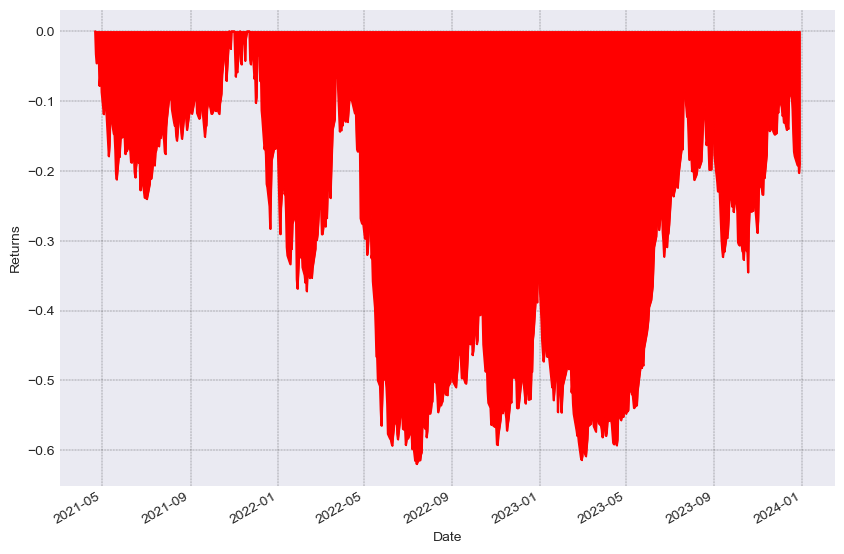

In [75]:
drawdown_buy_n_hold = calc_drawdown(buy_and_hold_returns)
print("The maximum drawdown of the bnh strategy is %.2f" % (drawdown_buy_n_hold.min()*100))
plot_drawdown(drawdown_strategy)

In [76]:
sharpe_ratio = (data_test['strategy_returns'].mean()*252)/(data_test['strategy_returns'].std()*np.sqrt(252))
print("The sharpe ratio of the strategy is %.2f" % sharpe_ratio)

The sharpe ratio of the strategy is 0.39


[*********************100%***********************]  1 of 1 completed


No missing values in the data.
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=14541.155, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=13680.305, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=14539.157, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=13181.609, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=12983.709, Time=0.30 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=12970.894, Time=0.36 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=12840.214, Time=0.45 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=12838.215, Time=0.36 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=12968.898, Time=0.31 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(4,2,1)(0,0,

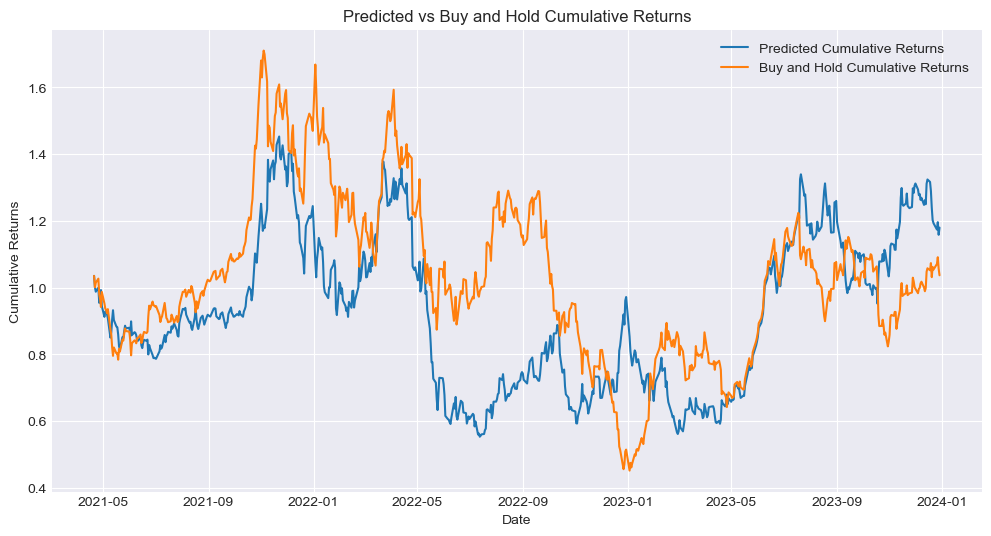

In [77]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

class StockForecasting:
    def __init__(self, symbol, start, end):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.data = self.download_data()
        self.data = self.sanity_check(self.data)
        self.best_param = None

    def download_data(self):
        """Download stock data from Yahoo Finance."""
        data = yf.download(self.symbol, start=self.start, end=self.end, interval='1d')[['Adj Close']]
        return data

    def sanity_check(self, data):
        """Check for missing values and handle them."""
        if data.isnull().values.any():
            print("Missing values found.")
            data.fillna(method='ffill', inplace=True)
            print("Missing values have been forward-filled.")
        else:
            print("No missing values in the data.")
        return data

    def check_stationarity(self, df):
        """Check for stationarity of the data."""
        adf_result = adfuller(df)
        return adf_result[1] < 0.05

    def plot_acf_pacf(self, diff_data):
        """Plot ACF and PACF for the differenced data."""
        plt.figure(figsize=(14, 7))
        plt.subplot(121)
        plot_acf(diff_data, ax=plt.gca(), lags=40)
        plt.title('Autocorrelation Function')
        plt.subplot(122)
        plot_pacf(diff_data, ax=plt.gca(), lags=40)
        plt.title('Partial Autocorrelation Function')
        plt.tight_layout()
        plt.show()

    def find_best_arima_parameters(self):
        """Find the best ARIMA parameters using auto_arima."""
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        model = pm.auto_arima(data_train['Adj Close'], seasonal=False, trace=True, 
                               error_action='ignore', suppress_warnings=True)
        self.best_param = model.order
        print(model.summary())
        return self.best_param

    def get_predicted_prices(self, close_prices):
        """Get predicted prices using the best ARIMA model."""
        best_model = ARIMA(close_prices.values, order=self.best_param)
        best_model_fit = best_model.fit(method_kwargs={"warn_convergence": False})
        predictions = best_model_fit.forecast(steps=1)[0]
        return predictions

    def run_forecasting(self):
        """Run the forecasting process and evaluate the strategy."""
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        data_test = self.data[split:]

        predictions = []
        for i in range(len(data_test['Adj Close'])):
            current_data = pd.concat([data_train['Adj Close'], data_test['Adj Close'].iloc[:i]])
            next_pred = self.get_predicted_prices(current_data)
            predictions.append(next_pred)

        predictions_df = pd.DataFrame(predictions, columns=['predicted_price'])
        predictions_df.index = data_test.index
        data_test = pd.concat([data_test, predictions_df], axis=1)

        # Generate signals and returns
        data_test['predicted_returns'] = data_test['predicted_price'].pct_change()
        data_test['actual_returns'] = data_test['Adj Close'].pct_change()
        data_test.dropna(inplace=True)
        data_test['signal'] = np.where(data_test['predicted_returns'] >= 0, 1, -1)
        data_test['strategy_returns'] = data_test['signal'] * data_test['actual_returns']
        data_test['cumulative_returns'] = np.cumprod(data_test['strategy_returns'] + 1)

        # Buy and hold returns
        buy_and_hold_returns = (1 + data_test['actual_returns']).cumprod()

        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(data_test['cumulative_returns'], label='Predicted Cumulative Returns')
        plt.plot(buy_and_hold_returns, label='Buy and Hold Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.title('Predicted vs Buy and Hold Cumulative Returns')
        plt.legend()
        plt.show()

        return data_test

# Example usage:
if __name__ == "__main__":
    symbol = 'TSLA'
    start = '2010-01-01'
    end = '2023-12-31'
    
    stock_forecast = StockForecasting(symbol, start, end)
    stock_forecast.find_best_arima_parameters()
    results = stock_forecast.run_forecasting()


[*********************100%***********************]  1 of 1 completed


No missing values in the data.
ADF Statistic: -1.6910422905186058
p-value: 0.43573356766280014
Critical Values: {'1%': -3.4356006420838963, '5%': -2.8638586845641063, '10%': -2.5680044958343604}
The data is not stationary.
Differenced data with lag 1:
Date
2019-01-03   -0.650667
2019-01-04    1.155333
2019-01-07    1.151335
2019-01-08    0.025999
2019-01-09    0.212000
Name: Adj Close, dtype: float64


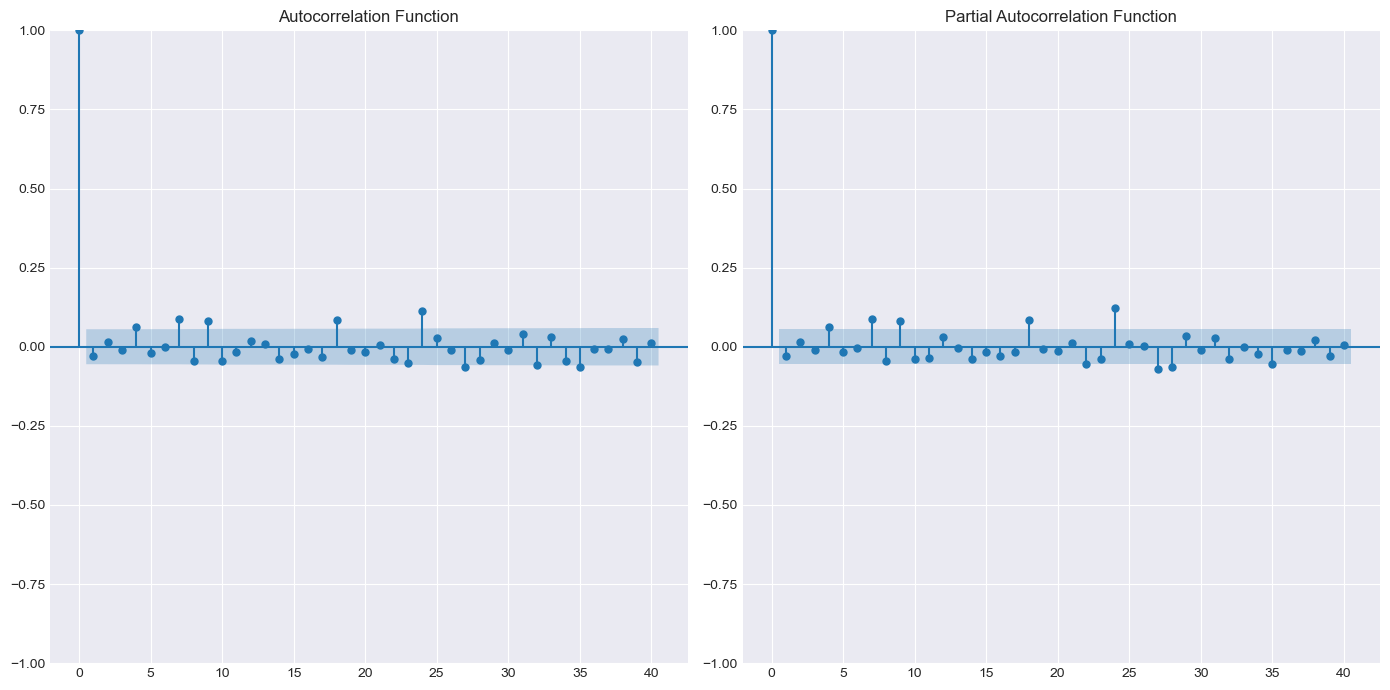

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6984.988, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6979.066, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6979.577, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6979.636, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6977.205, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6981.010, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.354 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1006
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3487.603
Date:                Fri, 20 Sep 2024   AIC                           6977.205
Time:                        14:35:38   BIC                           6982.118
Sample:                             0   HQIC                          6979.072
          

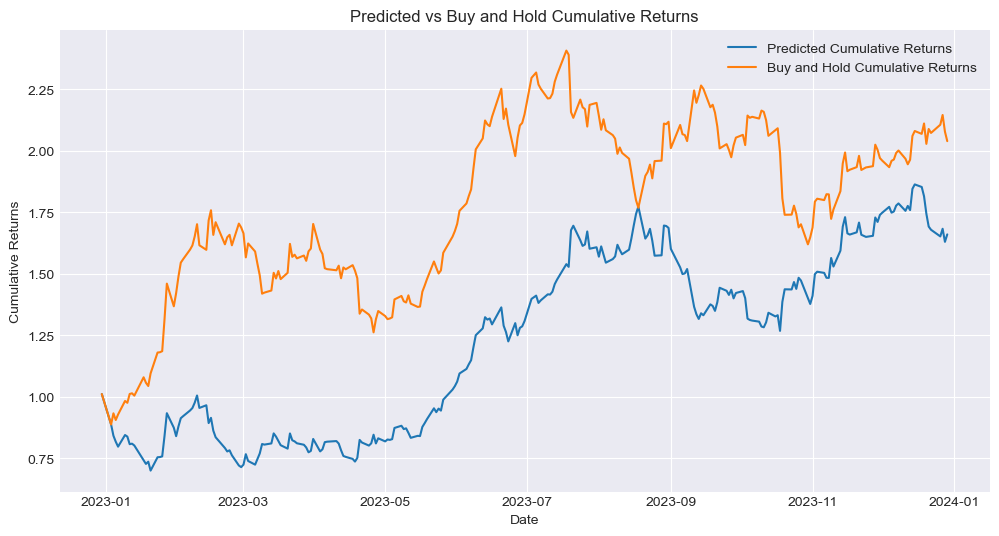

In [78]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

class StockForecasting:
    def __init__(self, symbol, start, end):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.data = self.download_data()
        self.data = self.sanity_check(self.data)
        self.diff_data = None
        self.best_param = None

    def download_data(self):
        """Download stock data from Yahoo Finance."""
        data = yf.download(self.symbol, start=self.start, end=self.end, interval='1d')[['Adj Close']]
        return data

    def sanity_check(self, data):
        """Check for missing values and handle them."""
        if data.isnull().values.any():
            print("Missing values found.")
            data.fillna(method='ffill', inplace=True)
            print("Missing values have been forward-filled.")
        else:
            print("No missing values in the data.")
        return data

    def check_stationarity(self, df):
        """Check for stationarity of the data using the ADF test."""
        adf_result = adfuller(df)
        p_value = adf_result[1]
        print(f"ADF Statistic: {adf_result[0]}")
        print(f"p-value: {adf_result[1]}")
        print(f"Critical Values: {adf_result[4]}")
        
        if p_value < 0.05:
            print('The data is stationary.')
            return True
        else:
            print('The data is not stationary.')
            return False

    def apply_differencing(self, lag=1):
        """Apply differencing to the series."""
        self.diff_data = self.data['Adj Close'].diff(periods=lag).dropna()
        print(f"Differenced data with lag {lag}:")
        print(self.diff_data.head())
        return self.diff_data

    def plot_acf_pacf(self, diff_data):
        """Plot ACF and PACF for the differenced data."""
        plt.figure(figsize=(14, 7))
        plt.subplot(121)
        plot_acf(diff_data, ax=plt.gca(), lags=40)
        plt.title('Autocorrelation Function')
        plt.subplot(122)
        plot_pacf(diff_data, ax=plt.gca(), lags=40)
        plt.title('Partial Autocorrelation Function')
        plt.tight_layout()
        plt.show()

    def find_best_arima_parameters(self):
        """Find the best ARIMA parameters using auto_arima."""
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        model = pm.auto_arima(data_train['Adj Close'], seasonal=False, trace=True, 
                               error_action='ignore', suppress_warnings=True)
        self.best_param = model.order
        print(model.summary())
        return self.best_param

    def get_predicted_prices(self, close_prices):
        """Get predicted prices using the best ARIMA model."""
        best_model = ARIMA(close_prices.values, order=self.best_param)
        best_model_fit = best_model.fit(method_kwargs={"warn_convergence": False})
        predictions = best_model_fit.forecast(steps=1)[0]
        return predictions

    def run_forecasting(self):
        """Run the forecasting process and evaluate the strategy."""
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        data_test = self.data[split:]

        predictions = []
        for i in range(len(data_test['Adj Close'])):
            current_data = pd.concat([data_train['Adj Close'], data_test['Adj Close'].iloc[:i]])
            next_pred = self.get_predicted_prices(current_data)
            predictions.append(next_pred)

        predictions_df = pd.DataFrame(predictions, columns=['predicted_price'])
        predictions_df.index = data_test.index
        data_test = pd.concat([data_test, predictions_df], axis=1)

        # Generate signals and returns
        data_test['predicted_returns'] = data_test['predicted_price'].pct_change()
        data_test['actual_returns'] = data_test['Adj Close'].pct_change()
        data_test.dropna(inplace=True)
        data_test['signal'] = np.where(data_test['predicted_returns'] >= 0, 1, -1)
        data_test['strategy_returns'] = data_test['signal'] * data_test['actual_returns']
        data_test['cumulative_returns'] = np.cumprod(data_test['strategy_returns'] + 1)

        # Buy and hold returns
        buy_and_hold_returns = (1 + data_test['actual_returns']).cumprod()

        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(data_test['cumulative_returns'], label='Predicted Cumulative Returns')
        plt.plot(buy_and_hold_returns, label='Buy and Hold Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.title('Predicted vs Buy and Hold Cumulative Returns')
        plt.legend()
        plt.show()

        return data_test

# Example usage:
if __name__ == "__main__":
    symbol = 'TSLA'
    start = '2019-01-01'
    end = '2023-12-31'
    
    stock_forecast = StockForecasting(symbol, start, end)
    
    # Check if the series is stationary
    is_stationary = stock_forecast.check_stationarity(stock_forecast.data['Adj Close'])
    
    # If not stationary, apply differencing
    if not is_stationary:
        stock_forecast.apply_differencing(lag=1)
        stock_forecast.plot_acf_pacf(stock_forecast.diff_data)
    
    stock_forecast.find_best_arima_parameters()
    results = stock_forecast.run_forecasting()


[*********************100%***********************]  1 of 1 completed


No missing values in the data.
ADF Statistic: -1.6910422905186058
p-value: 0.43573356766280014
Critical Values: {'1%': -3.4356006420838963, '5%': -2.8638586845641063, '10%': -2.5680044958343604}
The data is not stationary.
Differenced data with lag 1:
Date
2019-01-03   -0.650667
2019-01-04    1.155333
2019-01-07    1.151335
2019-01-08    0.025999
2019-01-09    0.212000
Name: Adj Close, dtype: float64


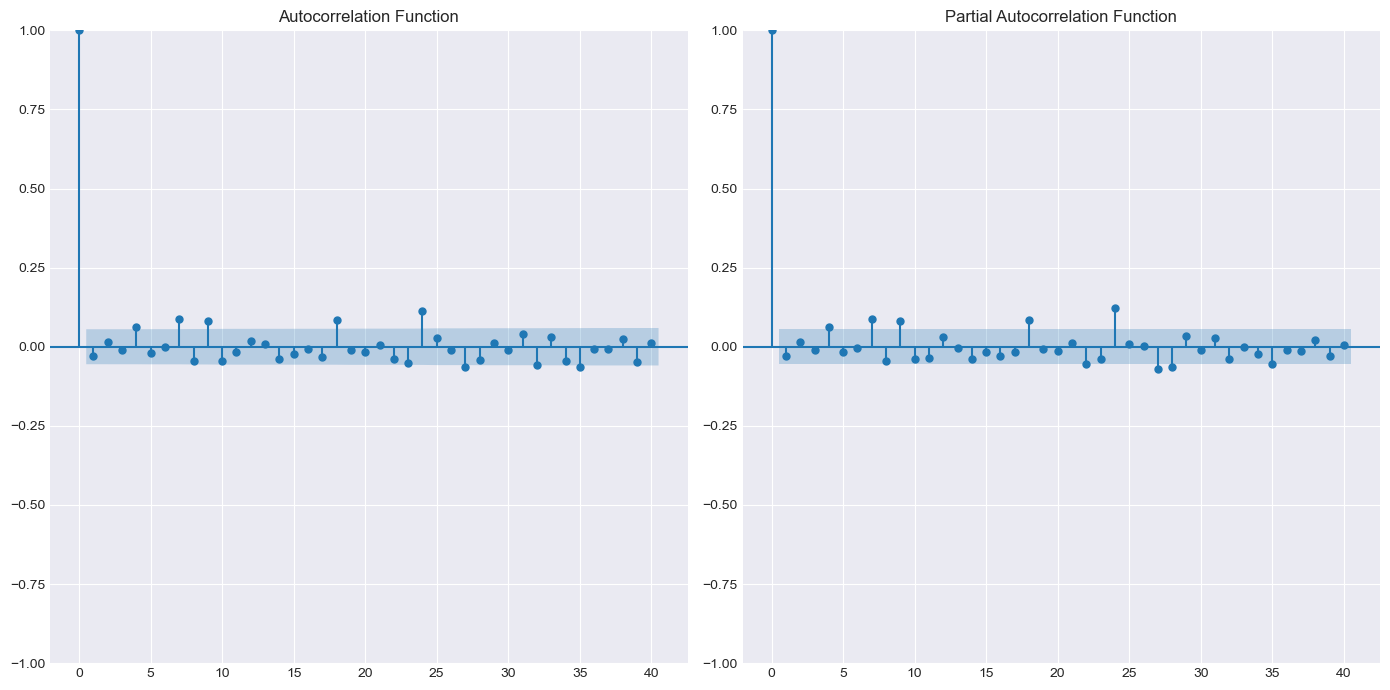

Finding the best ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6984.988, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6979.066, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6979.577, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6979.636, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6977.205, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6981.010, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.330 seconds
Initial best model based on AIC: (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1006
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3487.603
Date:                Fri, 20 Sep 2024   AIC                           6977.205
Time:                        14:39:00   BIC                           6982.118
Sample:       

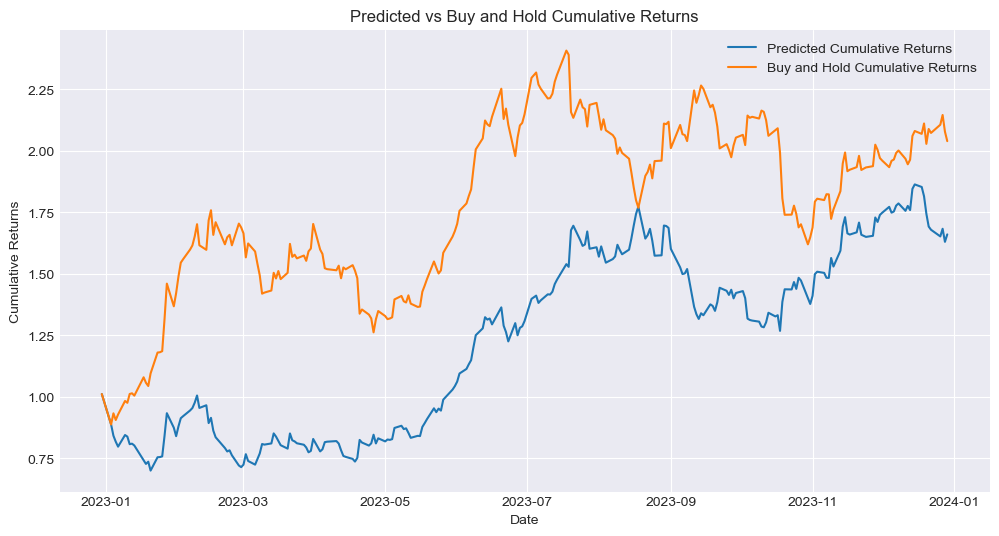

In [79]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

class StockForecasting:
    def __init__(self, symbol, start, end, p_value_threshold=0.05):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.p_value_threshold = p_value_threshold
        self.data = self.download_data()
        self.data = self.sanity_check(self.data)
        self.diff_data = None
        self.best_param = None

    def download_data(self):
        """Download stock data from Yahoo Finance."""
        data = yf.download(self.symbol, start=self.start, end=self.end, interval='1d')[['Adj Close']]
        return data

    def sanity_check(self, data):
        """Check for missing values and handle them."""
        if data.isnull().values.any():
            print("Missing values found.")
            data.fillna(method='ffill', inplace=True)
            print("Missing values have been forward-filled.")
        else:
            print("No missing values in the data.")
        return data

    def check_stationarity(self, df):
        """Check for stationarity of the data using the ADF test."""
        adf_result = adfuller(df)
        p_value = adf_result[1]
        print(f"ADF Statistic: {adf_result[0]}")
        print(f"p-value: {adf_result[1]}")
        print(f"Critical Values: {adf_result[4]}")
        
        if p_value < 0.05:
            print('The data is stationary.')
            return True
        else:
            print('The data is not stationary.')
            return False

    def apply_differencing(self, lag=1):
        """Apply differencing to the series."""
        self.diff_data = self.data['Adj Close'].diff(periods=lag).dropna()
        print(f"Differenced data with lag {lag}:")
        print(self.diff_data.head())
        return self.diff_data

    def plot_acf_pacf(self, diff_data):
        """Plot ACF and PACF for the differenced data."""
        plt.figure(figsize=(14, 7))
        plt.subplot(121)
        plot_acf(diff_data, ax=plt.gca(), lags=40)
        plt.title('Autocorrelation Function')
        plt.subplot(122)
        plot_pacf(diff_data, ax=plt.gca(), lags=40)
        plt.title('Partial Autocorrelation Function')
        plt.tight_layout()
        plt.show()

    def find_best_arima_parameters(self):
        """Find the best ARIMA parameters using auto_arima based on AIC and significant terms."""
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        print("Finding the best ARIMA model...")
        
        # Use auto_arima to get the initial best model based on AIC
        model = pm.auto_arima(data_train['Adj Close'], seasonal=False, trace=True, 
                               error_action='ignore', suppress_warnings=True, 
                               stepwise=True, criterion='aic')
        self.best_param = model.order

        print(f"Initial best model based on AIC: {self.best_param}")
        print(model.summary())

        # Validate model by ensuring no insignificant terms (based on p-value threshold)
        arima_model = ARIMA(data_train['Adj Close'], order=self.best_param)
        arima_model_fit = arima_model.fit()

        p_values = arima_model_fit.pvalues
        print(f"P-values for model terms: {p_values}")

        # Check if all terms have p-values below the threshold
        if all(p_values < self.p_value_threshold):
            print(f"Selected model {self.best_param} passes the p-value threshold check.")
        else:
            print(f"Some terms in the model {self.best_param} are not significant.")
            # If model has insignificant terms, use stepwise search to refine
            refined_model = pm.auto_arima(data_train['Adj Close'], seasonal=False, 
                                          trace=True, error_action='ignore', 
                                          suppress_warnings=True, stepwise=True, 
                                          criterion='aic', alpha=self.p_value_threshold)
            self.best_param = refined_model.order
            print(f"Refined model after checking p-values: {self.best_param}")
            print(refined_model.summary())
        
        return self.best_param

    def get_predicted_prices(self, close_prices):
        """Get predicted prices using the best ARIMA model."""
        best_model = ARIMA(close_prices.values, order=self.best_param)
        best_model_fit = best_model.fit(method_kwargs={"warn_convergence": False})
        predictions = best_model_fit.forecast(steps=1)[0]
        return predictions

    def run_forecasting(self):
        """Run the forecasting process and evaluate the strategy."""
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        data_test = self.data[split:]

        predictions = []
        for i in range(len(data_test['Adj Close'])):
            current_data = pd.concat([data_train['Adj Close'], data_test['Adj Close'].iloc[:i]])
            next_pred = self.get_predicted_prices(current_data)
            predictions.append(next_pred)

        predictions_df = pd.DataFrame(predictions, columns=['predicted_price'])
        predictions_df.index = data_test.index
        data_test = pd.concat([data_test, predictions_df], axis=1)

        # Generate signals and returns
        data_test['predicted_returns'] = data_test['predicted_price'].pct_change()
        data_test['actual_returns'] = data_test['Adj Close'].pct_change()
        data_test.dropna(inplace=True)
        data_test['signal'] = np.where(data_test['predicted_returns'] >= 0, 1, -1)
        data_test['strategy_returns'] = data_test['signal'] * data_test['actual_returns']
        data_test['cumulative_returns'] = np.cumprod(data_test['strategy_returns'] + 1)

        # Buy and hold returns
        buy_and_hold_returns = (1 + data_test['actual_returns']).cumprod()

        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(data_test['cumulative_returns'], label='Predicted Cumulative Returns')
        plt.plot(buy_and_hold_returns, label='Buy and Hold Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.title('Predicted vs Buy and Hold Cumulative Returns')
        plt.legend()
        plt.show()

        return data_test

# Example usage:
if __name__ == "__main__":
    symbol = 'TSLA'
    start = '2019-01-01'
    end = '2023-12-31'
    p_value_threshold = 0.05  # Set a custom p-value threshold
    
    stock_forecast = StockForecasting(symbol, start, end, p_value_threshold)
    
    # Check if the series is stationary
    is_stationary = stock_forecast.check_stationarity(stock_forecast.data['Adj Close'])
    
    # If not stationary, apply differencing
    if not is_stationary:
        stock_forecast.apply_differencing(lag=1)
        stock_forecast.plot_acf_pacf(stock_forecast.diff_data)
    
    stock_forecast.find_best_arima_parameters()
    results = stock_forecast.run_forecasting()


[*********************100%***********************]  1 of 1 completed


No missing values in the data.
ADF Statistic: -1.2452431505064323
p-value: 0.6538369391558434
Critical Values: {'1%': -3.4355671297788666, '5%': -2.8638438984080117, '10%': -2.5679966213893057}
Differenced data with lag 1:
Date
2019-01-03   -1.456898
2019-01-04    2.623505
2019-01-07   -0.107231
2019-01-08    0.471333
2019-01-09   -0.185543
Name: Adj Close, dtype: float64


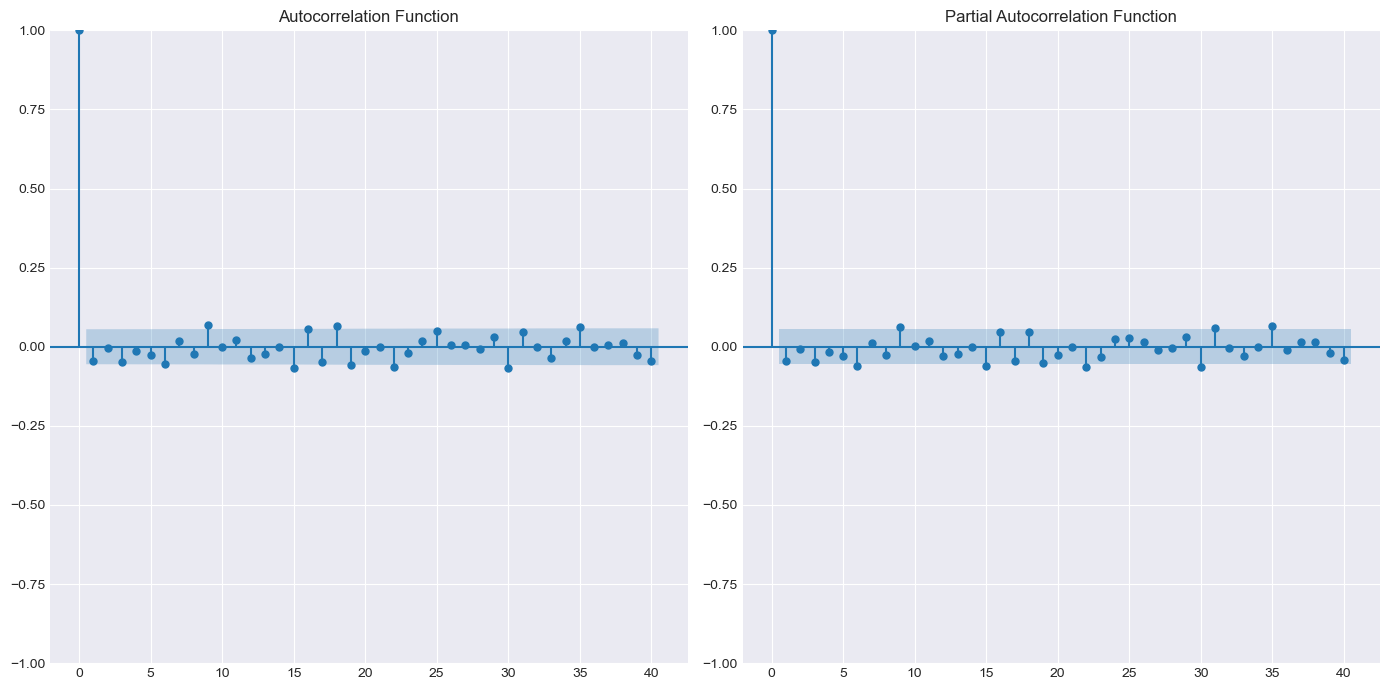

Finding the best ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4140.973, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4141.148, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4138.167, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4138.151, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4139.454, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4140.167, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4140.140, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4140.078, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4136.510, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4138.522, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4138.502, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4136.523, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4138.552, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.61

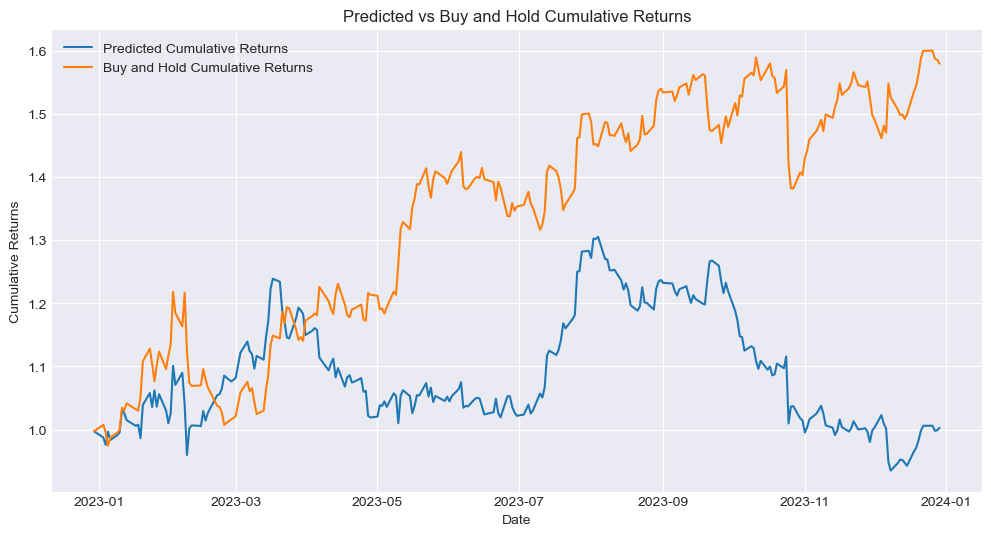

Percent of simulations exceeding 0.02 in each forecast period: [100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


In [81]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

class StockForecasting:
    def __init__(self, symbol, start, end, p_value_threshold=0.05):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.p_value_threshold = p_value_threshold
        self.data = self.download_data()
        self.data = self.sanity_check(self.data)
        self.diff_data = None
        self.best_param = None
        self.model_fit = None

    def download_data(self):
        """Download stock data from Yahoo Finance."""
        data = yf.download(self.symbol, start=self.start, end=self.end, interval='1d')[['Adj Close']]
        return data

    def sanity_check(self, data):
        """Check for missing values and handle them."""
        if data.isnull().values.any():
            print("Missing values found.")
            data.fillna(method='ffill', inplace=True)
            print("Missing values have been forward-filled.")
        else:
            print("No missing values in the data.")
        return data

    def check_stationarity(self, df):
        """Check for stationarity of the data using the ADF test."""
        adf_result = adfuller(df)
        p_value = adf_result[1]
        print(f"ADF Statistic: {adf_result[0]}")
        print(f"p-value: {adf_result[1]}")
        print(f"Critical Values: {adf_result[4]}")
        
        return p_value < 0.05

    def apply_differencing(self, lag=1):
        """Apply differencing to the series."""
        self.diff_data = self.data['Adj Close'].diff(periods=lag).dropna()
        print(f"Differenced data with lag {lag}:")
        print(self.diff_data.head())
        return self.diff_data

    def plot_acf_pacf(self, diff_data):
        """Plot ACF and PACF for the differenced data."""
        plt.figure(figsize=(14, 7))
        plt.subplot(121)
        plot_acf(diff_data, ax=plt.gca(), lags=40)
        plt.title('Autocorrelation Function')
        plt.subplot(122)
        plot_pacf(diff_data, ax=plt.gca(), lags=40)
        plt.title('Partial Autocorrelation Function')
        plt.tight_layout()
        plt.show()

    def find_best_arima_parameters(self):
        """Find the best ARIMA parameters using auto_arima based on AIC and significant terms."""
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        print("Finding the best ARIMA model...")
        
        # Use auto_arima to get the initial best model based on AIC
        model = pm.auto_arima(data_train['Adj Close'], seasonal=False, trace=True, 
                               error_action='ignore', suppress_warnings=True, 
                               stepwise=True, criterion='aic')
        self.best_param = model.order

        print(f"Initial best model based on AIC: {self.best_param}")
        print(model.summary())

        # Validate model by ensuring no insignificant terms (based on p-value threshold)
        arima_model = ARIMA(data_train['Adj Close'], order=self.best_param)
        self.model_fit = arima_model.fit()

        p_values = self.model_fit.pvalues
        print(f"P-values for model terms: {p_values}")

        # Check if all terms have p-values below the threshold
        if all(p_values < self.p_value_threshold):
            print(f"Selected model {self.best_param} passes the p-value threshold check.")
        else:
            print(f"Some terms in the model {self.best_param} are not significant.")
            # If model has insignificant terms, use stepwise search to refine
            refined_model = pm.auto_arima(data_train['Adj Close'], seasonal=False, 
                                          trace=True, error_action='ignore', 
                                          suppress_warnings=True, stepwise=True, 
                                          criterion='aic', alpha=self.p_value_threshold)
            self.best_param = refined_model.order
            self.model_fit = refined_model.fit()
            print(f"Refined model after checking p-values: {self.best_param}")
            print(self.model_fit.summary())
        
        return self.best_param

    def get_predicted_prices(self, close_prices):
        """Get predicted prices using the best ARIMA model."""
        best_model = ARIMA(close_prices.values, order=self.best_param)
        best_model_fit = best_model.fit(method_kwargs={"warn_convergence": False})
        predictions = best_model_fit.forecast(steps=1)[0]
        return predictions

    def run_forecasting(self):
        """Run the forecasting process and evaluate the strategy."""
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        data_test = self.data[split:]

        predictions = []
        for i in range(len(data_test['Adj Close'])):
            current_data = pd.concat([data_train['Adj Close'], data_test['Adj Close'].iloc[:i]])
            next_pred = self.get_predicted_prices(current_data)
            predictions.append(next_pred)

        predictions_df = pd.DataFrame(predictions, columns=['predicted_price'])
        predictions_df.index = data_test.index
        data_test = pd.concat([data_test, predictions_df], axis=1)

        # Generate signals and returns
        data_test['predicted_returns'] = data_test['predicted_price'].pct_change()
        data_test['actual_returns'] = data_test['Adj Close'].pct_change()
        data_test.dropna(inplace=True)
        data_test['signal'] = np.where(data_test['predicted_returns'] >= 0, 1, -1)
        data_test['strategy_returns'] = data_test['signal'] * data_test['actual_returns']
        data_test['cumulative_returns'] = np.cumprod(data_test['strategy_returns'] + 1)

        # Buy and hold returns
        buy_and_hold_returns = (1 + data_test['actual_returns']).cumprod()

        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(data_test['cumulative_returns'], label='Predicted Cumulative Returns')
        plt.plot(buy_and_hold_returns, label='Buy and Hold Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.title('Predicted vs Buy and Hold Cumulative Returns')
        plt.legend()
        plt.show()

        return data_test

    def simulate_forecasts(self, num_simulations=10000, forecast_periods=10, threshold_value=None):
        """Simulate forecasts for the specified number of periods and simulations."""
        residuals = self.model_fit.resid
        noise_distribution = residuals / np.std(residuals)  # Standardized residuals
        forecast_results = np.zeros((num_simulations, forecast_periods))

        # Simulate forecasts
        for sim in range(num_simulations):
            simulated_noise = np.random.choice(noise_distribution, size=forecast_periods, replace=False)
            forecasted_values = self.model_fit.forecast(steps=forecast_periods) + simulated_noise
            forecast_results[sim, :] = forecasted_values

        # Calculate percentage of simulations exceeding the threshold value
        if threshold_value is not None:
            exceedance_percentages = np.mean(forecast_results > threshold_value, axis=0) * 100
            print(f"Percent of simulations exceeding {threshold_value} in each forecast period: {exceedance_percentages}")
            return exceedance_percentages

        return forecast_results

# Example usage:
if __name__ == "__main__":
    symbol = 'GOOGL'
    start = '2019-01-01'
    end = '2023-12-31'
    p_value_threshold = 0.05  # Set a custom p-value threshold
    
    stock_forecast = StockForecasting(symbol, start, end, p_value_threshold)
    
    # Check if the series is stationary
    is_stationary = stock_forecast.check_stationarity(stock_forecast.data['Adj Close'])
    
    # If not stationary, apply differencing
    if not is_stationary:
        stock_forecast.apply_differencing(lag=1)
        stock_forecast.plot_acf_pacf(stock_forecast.diff_data)
    
    stock_forecast.find_best_arima_parameters()
    results = stock_forecast.run_forecasting()
    
    # Simulate forecasts
    num_simulations = 10000  # Number of simulations
    forecast_periods = 10  # Number of forecast periods
    threshold_value = 0.02  # User-specified threshold value for exceedance

    stock_forecast.simulate_forecasts(num_simulations=num_simulations, forecast_periods=forecast_periods, threshold_value=threshold_value)


[*********************100%***********************]  1 of 1 completed


No missing values in the data.
ADF Statistic: -1.5208304003345947
p-value: 0.5231828288191838
Critical Values: {'1%': -3.4368734638130847, '5%': -2.8644201518188126, '10%': -2.5683035273879358}
Differenced data with lag 1:
Date
2020-01-03   -0.357109
2020-01-06    1.810013
2020-01-07   -0.134659
2020-01-08    0.495270
2020-01-09    0.735672
Name: Adj Close, dtype: float64


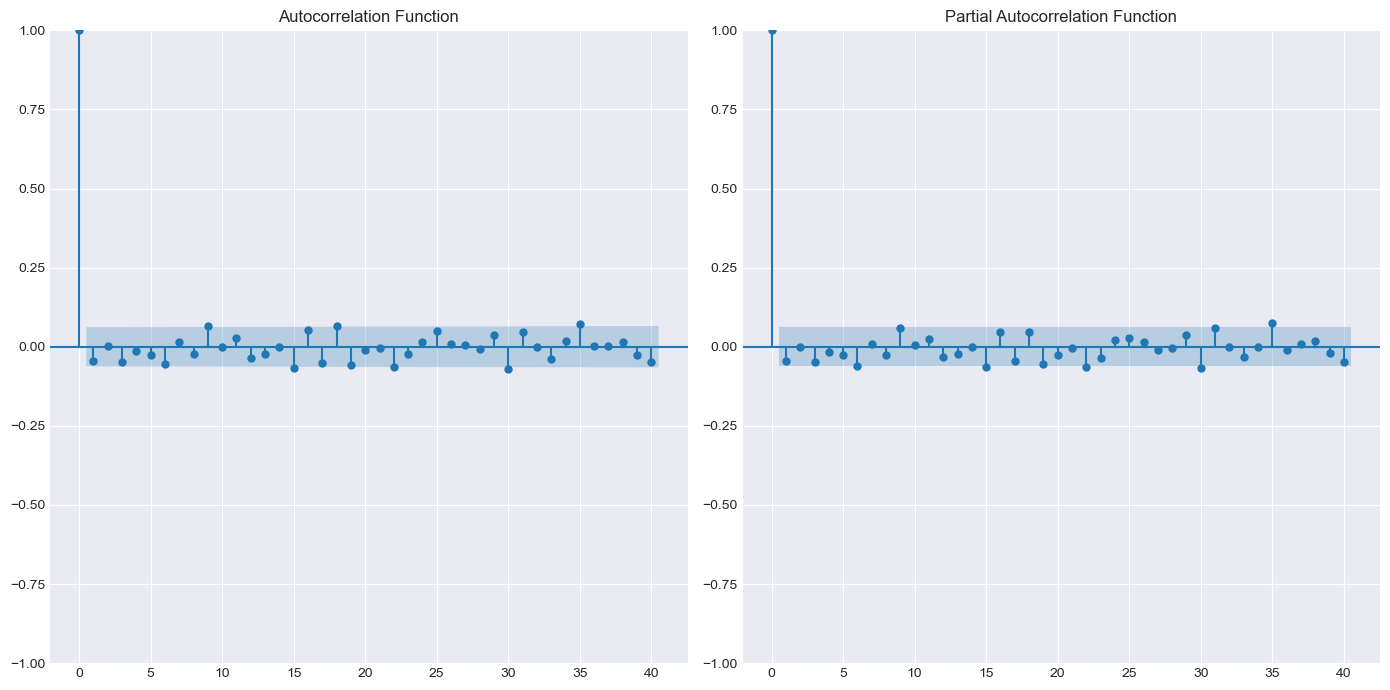

Finding the best ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3514.932, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3512.933, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3511.194, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3511.154, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3511.071, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3511.812, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.384 seconds
Initial best model based on AIC: (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  804
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1754.535
Date:                Fri, 20 Sep 2024   AIC                           3511.071
Time:                        18:48:35   BIC                           3515.759
Sample:       

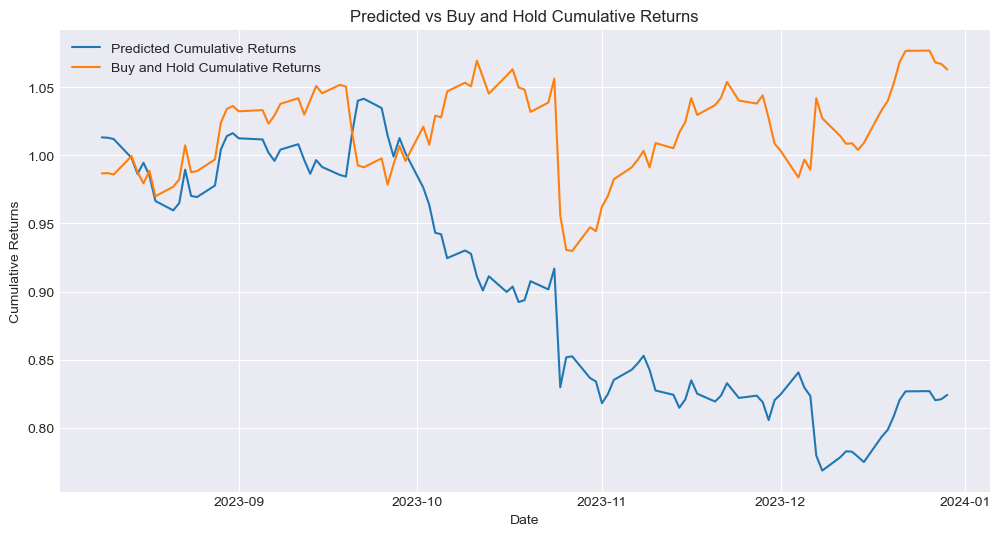

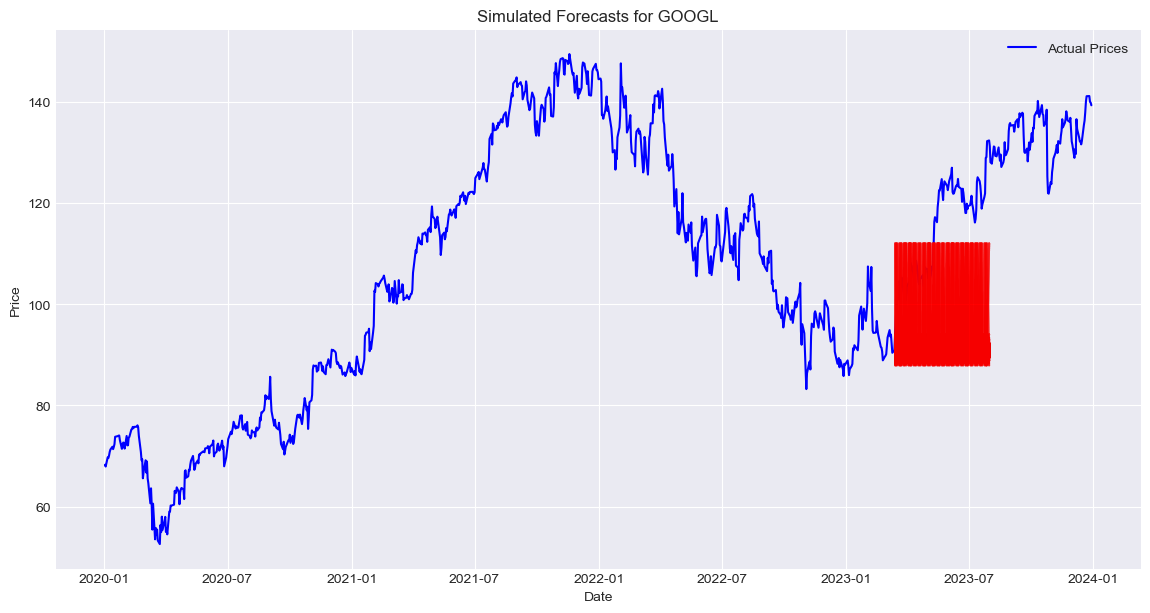

In [115]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

class StockForecasting:
    def __init__(self, symbol, start, end, p_value_threshold=0.05):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.p_value_threshold = p_value_threshold
        self.data = self.download_data()
        self.data = self.sanity_check(self.data)
        self.diff_data = None
        self.best_param = None
        self.model_fit = None

    def download_data(self):
        """Download stock data from Yahoo Finance."""
        data = yf.download(self.symbol, start=self.start, end=self.end, interval='1d')[['Adj Close']]
        return data

    def sanity_check(self, data):
        """Check for missing values and handle them."""
        if data.isnull().values.any():
            print("Missing values found.")
            data.fillna(method='ffill', inplace=True)
            print("Missing values have been forward-filled.")
        else:
            print("No missing values in the data.")
        return data

    def check_stationarity(self, df):
        """Check for stationarity of the data using the ADF test."""
        adf_result = adfuller(df)
        p_value = adf_result[1]
        print(f"ADF Statistic: {adf_result[0]}")
        print(f"p-value: {adf_result[1]}")
        print(f"Critical Values: {adf_result[4]}")
        
        return p_value < 0.05

    def apply_differencing(self, lag=1):
        """Apply differencing to the series."""
        self.diff_data = self.data['Adj Close'].diff(periods=lag).dropna()
        print(f"Differenced data with lag {lag}:")
        print(self.diff_data.head())
        return self.diff_data

    def plot_acf_pacf(self, diff_data):
        """Plot ACF and PACF for the differenced data."""
        plt.figure(figsize=(14, 7))
        plt.subplot(121)
        plot_acf(diff_data, ax=plt.gca(), lags=40)
        plt.title('Autocorrelation Function')
        plt.subplot(122)
        plot_pacf(diff_data, ax=plt.gca(), lags=40)
        plt.title('Partial Autocorrelation Function')
        plt.tight_layout()
        plt.show()

    def find_best_arima_parameters(self):
        """Find the best ARIMA parameters using auto_arima based on AIC and significant terms."""
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        print("Finding the best ARIMA model...")
        
        # Use auto_arima to get the initial best model based on AIC
        model = pm.auto_arima(data_train['Adj Close'], seasonal=False, trace=True, 
                               error_action='ignore', suppress_warnings=True, 
                               stepwise=True, criterion='aic')
        self.best_param = model.order

        print(f"Initial best model based on AIC: {self.best_param}")
        print(model.summary())

        # Validate model by ensuring no insignificant terms (based on p-value threshold)
        arima_model = ARIMA(data_train['Adj Close'], order=self.best_param)
        self.model_fit = arima_model.fit()

        p_values = self.model_fit.pvalues
        print(f"P-values for model terms: {p_values}")

        # Check if all terms have p-values below the threshold
        if all(p_values < self.p_value_threshold):
            print(f"Selected model {self.best_param} passes the p-value threshold check.")
        else:
            print(f"Some terms in the model {self.best_param} are not significant.")
            # If model has insignificant terms, use stepwise search to refine
            refined_model = pm.auto_arima(data_train['Adj Close'], seasonal=False, 
                                          trace=True, error_action='ignore', 
                                          suppress_warnings=True, stepwise=True, 
                                          criterion='aic', alpha=self.p_value_threshold)
            self.best_param = refined_model.order
            self.model_fit = refined_model.fit()
            print(f"Refined model after checking p-values: {self.best_param}")
            print(self.model_fit.summary())
        
        return self.best_param

    def get_predicted_prices(self, close_prices):
        """Get predicted prices using the best ARIMA model."""
        best_model = ARIMA(close_prices.values, order=self.best_param)
        best_model_fit = best_model.fit(method_kwargs={"warn_convergence": False})
        predictions = best_model_fit.forecast(steps=1)[0]
        return predictions

    def run_forecasting(self):
        """Run the forecasting process and evaluate the strategy."""
        split = int(len(self.data) * 0.9)
        data_train = self.data[:split]
        data_test = self.data[split:]

        predictions = []
        for i in range(len(data_test['Adj Close'])):
            current_data = pd.concat([data_train['Adj Close'], data_test['Adj Close'].iloc[:i]])
            next_pred = self.get_predicted_prices(current_data)
            predictions.append(next_pred)

        predictions_df = pd.DataFrame(predictions, columns=['predicted_price'])
        predictions_df.index = data_test.index
        data_test = pd.concat([data_test, predictions_df], axis=1)

        # Generate signals and returns
        data_test['predicted_returns'] = data_test['predicted_price'].pct_change()
        data_test['actual_returns'] = data_test['Adj Close'].pct_change()
        data_test.dropna(inplace=True)
        data_test['signal'] = np.where(data_test['predicted_returns'] >= 0, 1, -1)
        data_test['strategy_returns'] = data_test['signal'] * data_test['actual_returns']
        data_test['cumulative_returns'] = np.cumprod(data_test['strategy_returns'] + 1)

        # Buy and hold returns
        buy_and_hold_returns = (1 + data_test['actual_returns']).cumprod()

        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(data_test['cumulative_returns'], label='Predicted Cumulative Returns')
        plt.plot(buy_and_hold_returns, label='Buy and Hold Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.title('Predicted vs Buy and Hold Cumulative Returns')
        plt.legend()
        plt.show()

        return data_test


    def simulate_forecasts(self, num_simulations, forecast_periods):
        """Simulate forecasts for the specified number of periods and simulations."""
        residuals = self.model_fit.resid
        noise_distribution = residuals / np.std(residuals)  # Standardized residuals
        forecast_results = np.zeros((num_simulations, forecast_periods))

        # Simulate forecasts
        for sim in range(num_simulations):
            simulated_noise = np.random.choice(noise_distribution, size=forecast_periods, replace=False)
            forecasted_values = self.model_fit.forecast(steps=forecast_periods) + simulated_noise
            forecast_results[sim, :] = forecasted_values
            # print(forecast_results)


        #   # Calculate percentage of simulations exceeding the threshold value
        # if threshold_value is not None:
        #     exceedance_percentages = np.mean(forecast_results > threshold_value, axis=0) * 100
        #     print(f"Percent of simulations exceeding {threshold_value} in each forecast period: {exceedance_percentages}")
        #     return exceedance_percentages

        return forecast_results

    def plot_simulated_forecasts(self, num_simulations, forecast_periods):
        """Plot simulated forecasts along with actual values."""
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        last_observed = data_train['Adj Close'].values[-1]
        
        # Get simulated forecasts
        forecast_results = self.simulate_forecasts(num_simulations, forecast_periods)
        
        # Generate future dates for the forecasts
        future_dates = pd.date_range(start=data_train.index[-1] + pd.Timedelta(days=1), periods=forecast_periods, freq='B')

        # Plot actuals and simulated forecasts
        plt.figure(figsize=(14, 7))
        plt.plot(self.data['Adj Close'], label='Actual Prices', color='blue')
        
        for i in range(num_simulations):
            plt.plot(future_dates, forecast_results[i, :], color='red', alpha=0.1)

        plt.title(f'Simulated Forecasts for {self.symbol}')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

"""
AAPL - Apple Inc.
MSFT - Microsoft Corporation
GOOGL - Alphabet Inc. (Class A)
AMZN - Amazon.com, Inc.
TSLA - Tesla, Inc.
FB - Meta Platforms, Inc. (formerly Facebook)
BRK.B - Berkshire Hathaway Inc. (Class B)
NFLX - Netflix, Inc.
NVDA - NVIDIA Corporation
DIS - The Walt Disney Company

"""

# Example usage:
if __name__ == "__main__":
    symbol = 'GOOGL'
    start = '2020-01-01'
    end = '2023-12-31'
    p_value_threshold = 0.05  # Set a custom p-value threshold
    
    stock_forecast = StockForecasting(symbol, start, end, p_value_threshold)
    
    # Check if the series is stationary
    is_stationary = stock_forecast.check_stationarity(stock_forecast.data['Adj Close'])
    
    # If not stationary, apply differencing
    if not is_stationary:
        stock_forecast.apply_differencing(lag=1)
        stock_forecast.plot_acf_pacf(stock_forecast.diff_data)
    
    stock_forecast.find_best_arima_parameters()
    results = stock_forecast.run_forecasting()
    
    # Plot simulated forecasts
    num_simulations = 10000  # Number of simulations
    forecast_periods = 100  # Number of forecast periods
    stock_forecast.plot_simulated_forecasts(num_simulations=num_simulations, forecast_periods=forecast_periods)


[*********************100%***********************]  1 of 1 completed


No missing values in the data.
ADF Statistic: 0.6901505456843731
p-value: 0.9896392432628499
Critical Values: {'1%': -3.4322245674254277, '5%': -2.8623682773183745, '10%': -2.5672109065140374}
Differenced data with lag 1:
Date
2010-01-05   -0.068898
2010-01-06   -0.392671
2010-01-07   -0.353479
2010-01-08    0.197709
2010-01-11   -0.022716
Name: Adj Close, dtype: float64


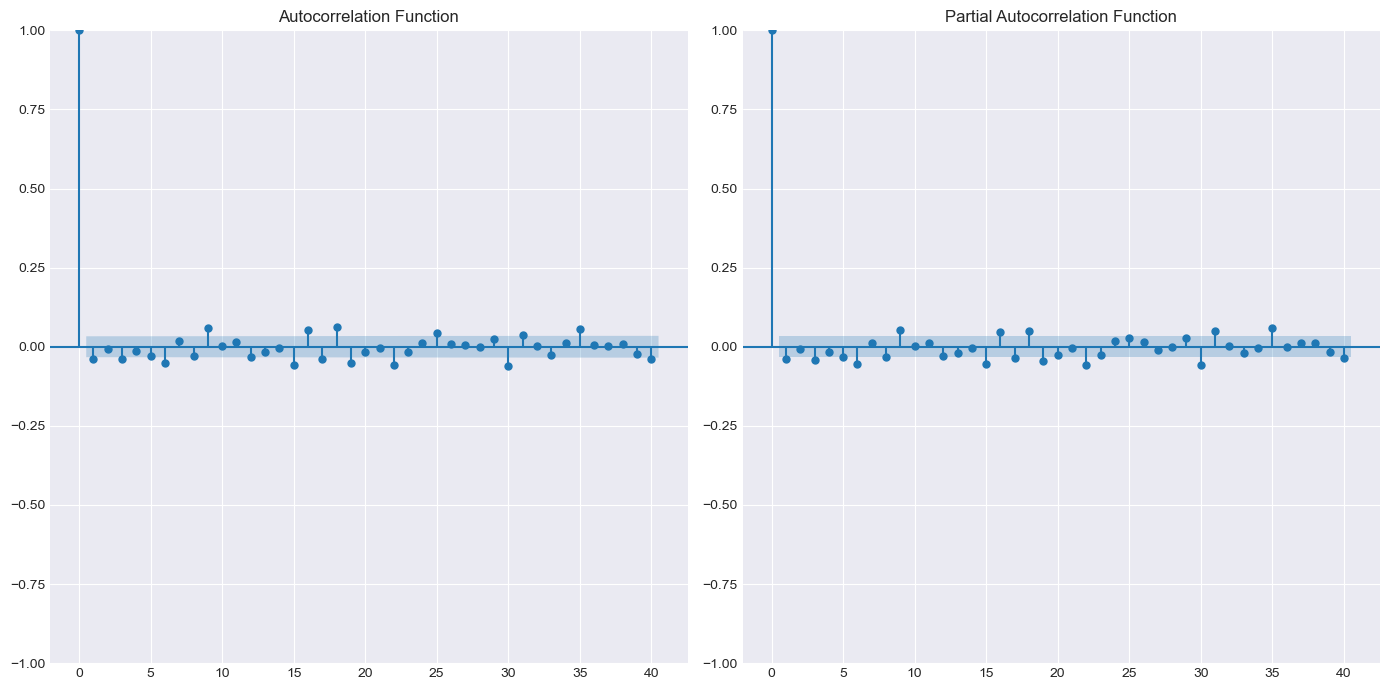

Finding the best ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6382.469, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6411.021, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6377.972, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6379.882, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6413.692, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6378.471, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6378.501, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6380.471, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6381.839, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.094 seconds
Initial best model based on AIC: (1, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2817
Model:               SARIMAX(1, 1, 0)   Log Likelihoo

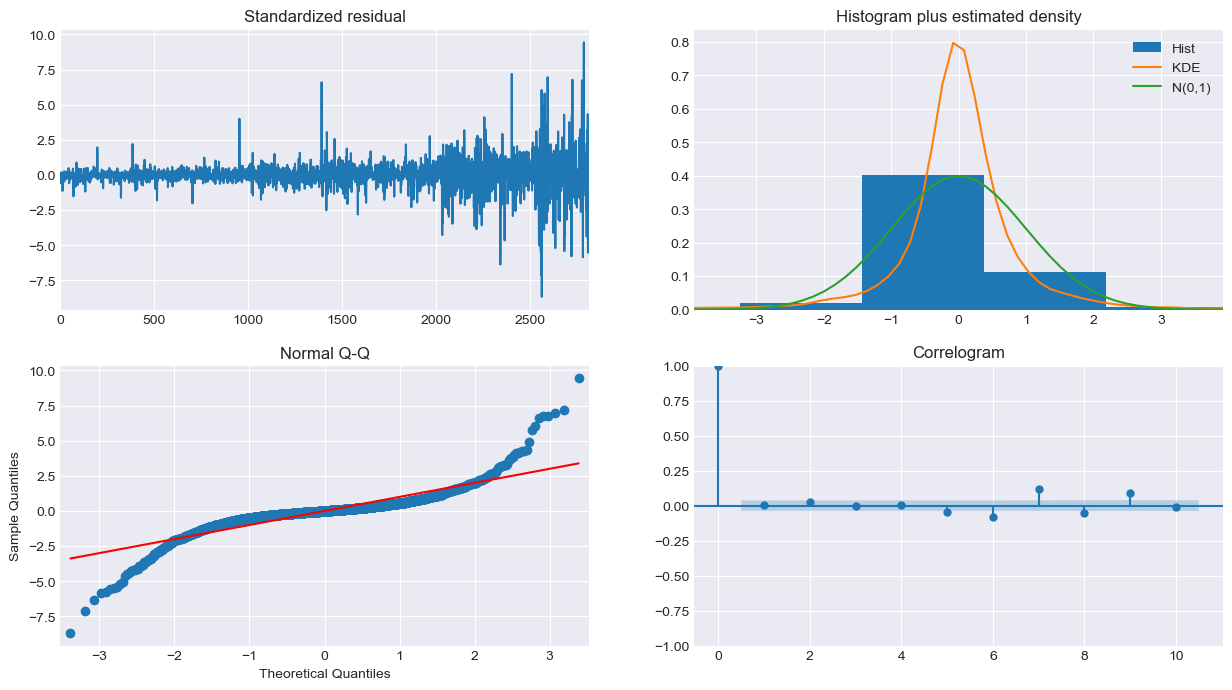

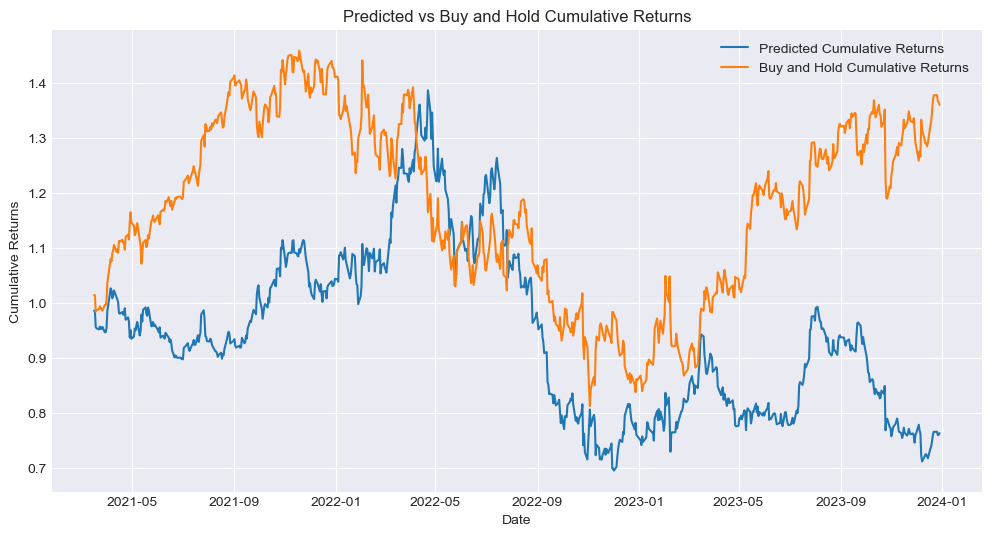

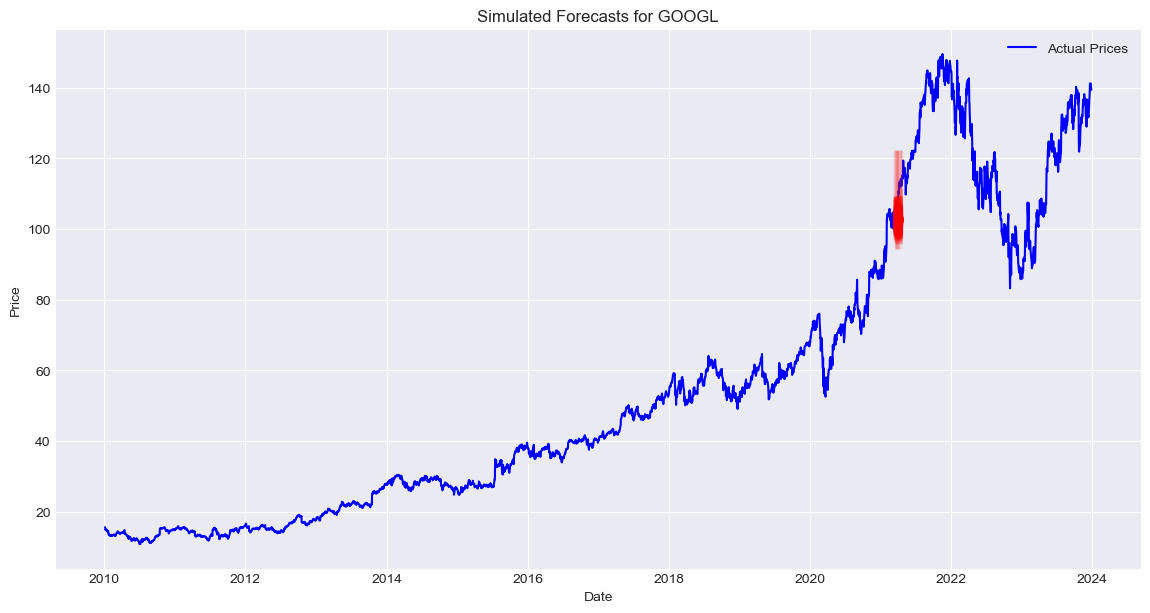

[[101.69686746 100.24573057 102.12420439 ... 102.75508967 102.52676521
  102.45533131]
 [103.16640335 103.07763366 102.4990861  ... 102.26304498 102.6737253
  101.40942441]
 [102.40118825 102.69282685 102.67544396 ... 102.52635012 100.90959816
  102.44008462]
 ...
 [102.59590622 102.66555655 102.56614253 ... 102.50082546 102.79973719
  101.69755033]
 [102.61900968 102.67520669 102.83801975 ... 102.73359047 102.65669606
  102.28569002]
 [105.1385578  104.02367598 102.83565385 ... 102.51464904 102.57700523
  102.46199815]]
         Date  Percentage Exceeding Threshold
0  2021-03-15                             0.0
1  2021-03-16                             0.0
2  2021-03-17                             0.0
3  2021-03-18                             0.0
4  2021-03-19                             0.0
5  2021-03-22                             0.0
6  2021-03-23                             0.0
7  2021-03-24                             0.0
8  2021-03-25                             0.0
9  2021-03-26

In [143]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error


class StockForecasting:
    def __init__(self, symbol, start, end, p_value_threshold=0.05):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.p_value_threshold = p_value_threshold
        self.data = self.download_data()
        self.data = self.sanity_check(self.data)
        self.diff_data = None
        self.best_param = None
        self.model_fit = None

    def download_data(self):
        """Download stock data from Yahoo Finance."""
        data = yf.download(self.symbol, start=self.start, end=self.end, interval='1d')[['Adj Close']]
        return data

    def sanity_check(self, data):
        """Check for missing values and handle them."""
        if data.isnull().values.any():
            print("Missing values found.")
            data.fillna(method='ffill', inplace=True)
            print("Missing values have been forward-filled.")
        else:
            print("No missing values in the data.")
        return data

    def check_stationarity(self, df):
        """Check for stationarity of the data using the ADF test."""
        adf_result = adfuller(df)
        p_value = adf_result[1]
        print(f"ADF Statistic: {adf_result[0]}")
        print(f"p-value: {adf_result[1]}")
        print(f"Critical Values: {adf_result[4]}")
        return p_value < 0.05

    def apply_differencing(self, lag=1):
        """Apply differencing to the series."""
        self.diff_data = self.data['Adj Close'].diff(periods=lag).dropna()
        print(f"Differenced data with lag {lag}:")
        print(self.diff_data.head())
        return self.diff_data

    def plot_acf_pacf(self, diff_data):
        """Plot ACF and PACF for the differenced data."""
        plt.figure(figsize=(14, 7))
        plt.subplot(121)
        plot_acf(diff_data, ax=plt.gca(), lags=40)
        plt.title('Autocorrelation Function')
        plt.subplot(122)
        plot_pacf(diff_data, ax=plt.gca(), lags=40)
        plt.title('Partial Autocorrelation Function')
        plt.tight_layout()
        plt.show()

    def find_best_arima_parameters(self):
        """Find the best ARIMA parameters using auto_arima based on AIC and significant terms."""
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        print("Finding the best ARIMA model...")

        # Use auto_arima to get the initial best model based on AIC
        model = pm.auto_arima(data_train['Adj Close'], seasonal=False, trace=True,
                               error_action='ignore', suppress_warnings=True,
                               stepwise=True, criterion='aic')
        self.best_param = model.order
        print(f"Initial best model based on AIC: {self.best_param}")
        print(model.summary())
        model.plot_diagnostics(figsize=(15,8))


        # Fit the model and check p-values
        arima_model = ARIMA(data_train['Adj Close'], order=self.best_param)
        self.model_fit = arima_model.fit()

        p_values = self.model_fit.pvalues
        print(f"P-values for model terms: {p_values}")

        # Validate model by ensuring no insignificant terms (based on p-value threshold)
        if all(p_values < self.p_value_threshold):
            print(f"Selected model {self.best_param} passes the p-value threshold check.")
        else:
            print(f"Some terms in the model {self.best_param} are not significant.")
            # Use stepwise search to refine
            refined_model = pm.auto_arima(data_train['Adj Close'], seasonal=False,
                                           trace=True, error_action='ignore',
                                           suppress_warnings=True, stepwise=True,
                                           criterion='aic', alpha=self.p_value_threshold)
            refined_model.plot_diagnostics(figsize=(15,8))
            self.best_param = refined_model.order
            self.model_fit = refined_model.fit()
            print(f"Refined model after checking p-values: {self.best_param}")
            print(self.model_fit.summary())

        return self.best_param

    def get_predicted_prices(self, close_prices):
        """Get predicted prices using the best ARIMA model."""
        best_model = ARIMA(close_prices.values, order=self.best_param)
        best_model_fit = best_model.fit(method_kwargs={"warn_convergence": False})
        predictions = best_model_fit.forecast(steps=1)[0]
        return predictions

    def run_forecasting(self):
        """Run the forecasting process and evaluate the strategy."""
        split = int(len(self.data) * 0.8)  # Adjusted split for better training/testing
        data_train = self.data[:split]
        data_test = self.data[split:]

        predictions = []
        for i in range(len(data_test['Adj Close'])):
            current_data = pd.concat([data_train['Adj Close'], data_test['Adj Close'].iloc[:i]])
            next_pred = self.get_predicted_prices(current_data)
            predictions.append(next_pred)

        predictions_df = pd.DataFrame(predictions, columns=['predicted_price'])
        predictions_df.index = data_test.index
        data_test = pd.concat([data_test, predictions_df], axis=1)

        # Generate signals and returns
        data_test['predicted_returns'] = data_test['predicted_price'].pct_change()
        data_test['actual_returns'] = data_test['Adj Close'].pct_change()
        data_test.dropna(inplace=True)
        data_test['signal'] = np.where(data_test['predicted_returns'] >= 0, 1, -1)
        data_test['strategy_returns'] = data_test['signal'] * data_test['actual_returns']
        data_test['cumulative_returns'] = np.cumprod(data_test['strategy_returns'] + 1)

        # Buy and hold returns
        buy_and_hold_returns = (1 + data_test['actual_returns']).cumprod()

        # Error Metrics
        mse = mean_squared_error(data_test['Adj Close'], data_test['predicted_price'])
        mae = mean_absolute_error(data_test['Adj Close'], data_test['predicted_price'])
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((data_test['Adj Close'] - data_test['predicted_price']) / data_test['Adj Close'])) * 100

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"Root Mean Squared Error (RMSE): {rmse}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape}%")



        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(data_test['cumulative_returns'], label='Predicted Cumulative Returns')
        plt.plot(buy_and_hold_returns, label='Buy and Hold Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.title('Predicted vs Buy and Hold Cumulative Returns')
        plt.legend()
        plt.show()

        return data_test

    def simulate_forecasts(self, num_simulations, forecast_periods):
        """Simulate forecasts for the specified number of periods and simulations."""
        residuals = self.model_fit.resid
        noise_distribution = residuals / np.std(residuals)  # Standardized residuals
        forecast_results = np.zeros((num_simulations, forecast_periods))

        # Simulate forecasts
        for sim in range(num_simulations):
            simulated_noise = np.random.choice(noise_distribution, size=forecast_periods, replace=True)
            forecasted_values = self.model_fit.forecast(steps=forecast_periods) + simulated_noise
            forecast_results[sim, :] = forecasted_values

        return forecast_results

    def percent_simulations_exceeding_value(self, threshold, num_simulations, forecast_periods):
        """Calculate the percentage of simulations exceeding a threshold in each forecast period."""
        forecast_results = self.simulate_forecasts(num_simulations, forecast_periods)
        print(forecast_results)
        # Calculate percentage of simulations exceeding the threshold in each period
        exceed_percentages = (forecast_results > threshold).mean(axis=0) * 100

        # Generate future dates for the forecasts
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        future_dates = pd.date_range(start=data_train.index[-1] + pd.Timedelta(days=1), periods=forecast_periods, freq='B')

        # Create a DataFrame with forecast period and percentage of simulations exceeding threshold
        exceed_df = pd.DataFrame({
            'Date': future_dates,
            'Percentage Exceeding Threshold': exceed_percentages
        })

        return exceed_df

    def plot_simulated_forecasts(self, num_simulations, forecast_periods):
        """Plot simulated forecasts along with actual values."""
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        
        # Get simulated forecasts
        forecast_results = self.simulate_forecasts(num_simulations, forecast_periods)
        
        # Generate future dates for the forecasts
        future_dates = pd.date_range(start=data_train.index[-1] + pd.Timedelta(days=1), periods=forecast_periods, freq='B')

        # Plot actuals and simulated forecasts
        plt.figure(figsize=(14, 7))
        plt.plot(self.data['Adj Close'], label='Actual Prices', color='blue')
        
        for i in range(num_simulations):
            plt.plot(future_dates, forecast_results[i, :], color='red', alpha=0.1)

        plt.title(f'Simulated Forecasts for {self.symbol}')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()


"""
AAPL - Apple Inc.
MSFT - Microsoft Corporation
GOOGL - Alphabet Inc. (Class A)
AMZN - Amazon.com, Inc.
TSLA - Tesla, Inc.
FB - Meta Platforms, Inc. (formerly Facebook)
BRK.B - Berkshire Hathaway Inc. (Class B)
NFLX - Netflix, Inc.
DIS - The Walt Disney Company

"""

# Example usage:
if __name__ == "__main__":
    symbol = 'GOOGL'
    start = '2010-01-01'
    end = '2023-12-31'
    p_value_threshold = 0.05  # Set a custom p-value threshold
    
    stock_forecast = StockForecasting(symbol, start, end, p_value_threshold)
    
    # Check if the series is stationary
    is_stationary = stock_forecast.check_stationarity(stock_forecast.data['Adj Close'])
    
    # If not stationary, apply differencing
    if not is_stationary:
        stock_forecast.apply_differencing(lag=1)
        stock_forecast.plot_acf_pacf(stock_forecast.diff_data)
    
    stock_forecast.find_best_arima_parameters()
    results = stock_forecast.run_forecasting()
    # print(results)

    # Plot simulated forecasts
    num_simulations = 1000  # Number of simulations
    forecast_periods = 30  # Number of forecast periods
    threshold_value = 80  # Example threshold (e.g., stock price of $80)

    stock_forecast.plot_simulated_forecasts(num_simulations=num_simulations, forecast_periods=forecast_periods)
    exceed_df = stock_forecast.percent_simulations_exceeding_value(threshold_value, num_simulations, forecast_periods)
    print(exceed_df)

    
